<a href="https://colab.research.google.com/github/DushyantKhinchi/DushyantKhinchi-Neural-Machine-Translation-with-attention-mechanism/blob/master/machine_translation_tensorflow_orig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural machine translation

In [ ]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 55kB/s 
     |████████████████████████████████| 3.1MB 38.9MB/s 
     |████████████████████████████████| 501kB 35.9MB/s 


In [1]:
import tensorflow as tf
import unicodedata
import string
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
keras = tf.keras
print(tf.__version__)

2.2.0


In [4]:
# !wget https://www.manythings.org/anki/fra-eng.zip
# !unzip  fra-eng.zip

In [5]:
SOS_token = 0
EOS_token = 1

In [6]:
os.chdir("gdrive/My Drive/Machine Translation")

In [7]:
language="fra.txt"

In [8]:
#counting number of lines

file = open(language, "r")
number_of_lines = 0

for line in file:
  line = line.strip("\n")
  number_of_lines += 1
  
file.close()

print("lines:", number_of_lines)

lines: 175623


In [9]:
with open(language,'r') as f:
        lines = f.readlines()
for i in range(0,10):
        print(lines[i])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)

Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)

Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)

Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)

Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)

Who?	Qui ?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)

Wow!	Ça alors !	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)

Fire!	Au feu !	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)

Help!	À l'aide !	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)

Jump.	Saute.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #2416938 (Phoenix)



This class below will map words in a particular language to the index.
This class has three dictionaries data structures.

word2int: to map each word to a unique index integer
int2word: to map index integer to the word
word2count: to map a word to its total count in the corpus 

We have three functions in our class


1)  ***addWord()*** function just adds a word as a key to the word2int dictionary with its corresponding index value. The opposite is done for the int2word dictionary. It also keep track of how many times we’ve come across a word when parsing our corpus to populate the class dictionaries and if we’ve already come across  a particular word, we desist from adding it to the word2int and int2word dictionaries and instead keep track of how many times it appears in our corpus using the word2count dictionary.



2) ***addSentence()*** does is to simply iterate through each sentence and for each sentence, it splits the sentence into words and implements the addWord function on each word in each sentence.

In [10]:
class Lang(object):
    def __init__(self, name):
        self.name = name
        self.word2int = {}#map words to integers
        self.word2count = {} #map words to their count in the corpus/ how many times a word is repeated in the corpus?
        self.int2word = {0 : "SOS", 1 : "EOS"} # map integers to tokens. just the opposite of word2int but has some initial values. EOS means End of Sentence token 
                                               # used to indicate the end of a sentence. Every sentence is going to have an EOS token. SOS means Start of Sentence token and is used to indicate the start of a sentence.)
        self.n_words = 2
        
    def addWord(self, word):
        if word not in self.word2int:
            self.word2int[word] = self.n_words 
            self.word2count[word] = 1 
            self.int2word[self.n_words] = word
            self.n_words += 1
            
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

Corpus consists of French words which may have some characters like ‘Ç’. For simplicity sake, we convert them into their normal corresponding ASCII characters(Ç → C). 

Also we create white spaces between words and punctuation attached to these words. (hello’s → hello s). This is to ensure that the presence of a punctuation does not create two words for a particular word (For example, different integers would be assign to “they’re” and "they are" although they have the same maeaning).

In [11]:
def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) \
                   if unicodedata.category(c) != "Mn")

In [12]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    
    s = re.sub(r"([!.?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z?.!]+", " ", s)  #re.sub() function is used to replace occurrences of a particular sub-string with another sub-string.
    return s

    #When the ^ character appears outside of [] matches the beginning of the line (or string). 
    #When the ^ character appears inside the [], it matches any character not appearing inside the [].

In [13]:
# re.sub(r'(\b[a-z]+) \1', r'\1', 'cat in the the hat')

Two helper functions are combined under ***load_dataset()*** to load the dataset as a list of list containing the pair of sentences.

In [14]:
def load_dataset():
    with open(language,'r') as f:
        lines = f.readlines()
    
    pairs = [[normalizeString(pair) for pair in 
              line.strip().split('\t')] for line in lines]
    return pairs

In [15]:
pairs = load_dataset()

In [16]:
pairs[0:10] #list of list containing the pair of sentences

[['go .', 'va !', 'cc by . france attribution tatoeba .org cm wittydev '],
 ['hi .', 'salut !', 'cc by . france attribution tatoeba .org cm aiji '],
 ['hi .', 'salut .', 'cc by . france attribution tatoeba .org cm gillux '],
 ['run !',
  'cours !',
  'cc by . france attribution tatoeba .org papabear sacredceltic '],
 ['run !',
  'courez !',
  'cc by . france attribution tatoeba .org papabear sacredceltic '],
 ['who ?', 'qui ?', 'cc by . france attribution tatoeba .org ck gillux '],
 ['wow !',
  'ca alors !',
  'cc by . france attribution tatoeba .org zifre zmoo '],
 ['fire !',
  'au feu !',
  'cc by . france attribution tatoeba .org spamster sacredceltic '],
 ['help !',
  'a l aide !',
  'cc by . france attribution tatoeba .org lukaszpp sysko '],
 ['jump .',
  'saute .',
  'cc by . france attribution tatoeba .org shishir phoenix ']]

To reduce the training time, we are going to filter out our dataset to remove sentences with more than ten words.

In [17]:
"""
Iterates through a sentence, breaks it into words and maps the word to its corresponding integer
value using the word2int dictionary which we implemented in the language class

"""
MAX_LENGTH = 10
def sentencetoIndexes(sentence, lang):
    indexes = [lang.word2int[word] for word in sentence.split()]
    indexes.append(EOS_token)
    return indexes

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

To populate the word2int dictionary in each Language class with words and assign a corresponding  integer to each word in a new function. Also since we are going to batch our dataset, we are going to apply padding to sentences with words less than the maximum length we proposed. Let’s see how to do this.

In [18]:
def build_lang(lang1, lang2, max_length=10):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    input_seq = []
    output_seq = []
    
    for pair in pairs:
        input_lang.addSentence(pair[1])  #french
        output_lang.addSentence(pair[0]) #english
    for pair in pairs:
        input_seq.append(sentencetoIndexes(pair[1], input_lang))
        output_seq.append(sentencetoIndexes(pair[0], output_lang))
    return keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=max_length, padding='post',
                                                      truncating='post'), \
keras.preprocessing.sequence.pad_sequences(output_seq, padding='post', truncating='post'), input_lang, output_lang

In [19]:
input_tensor, output_tensor, input_lang, output_lang = build_lang('fr', 'en')

In [20]:
input_lang.name

'fr'

In [21]:
print("input_tensor at index 10: {}".format(input_tensor[10]))
print("output_tensor at index 10: {}".format(output_tensor[10]))
print("corresponding integer value for 'nous' {}".format(input_lang.word2int['nous']))
print("corresponding integer value for 'she' {}".format(output_lang.word2int['she']))

input_tensor at index 10: [10 18  3  1  0  0  0  0  0  0]
output_tensor at index 10: [13  6  1  0  0  0  0  0  0  0]
corresponding integer value for 'nous' 98
corresponding integer value for 'she' 194


In [22]:
output_tensor.shape

(123935, 10)

In [23]:
#creating batches of size 16

BATCH_SIZE = 16
BUFFER_SIZE = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor)).shuffle(BUFFER_SIZE) #maintains a buffer of size 
dataset = dataset.batch(BATCH_SIZE)

# Seq2Seq model

There are several architectures of Recurrent Neural Networks, each suited for a particular group of tasks. For examples, many-to-one architecture for task such as sentiment analysis and one-to-many for music generation but we are going to employ the many-to-many architecture which is suited for tasks such as chat-bots and Neural Machine Translation.

The class of RNN used here is called Sequence to Sequence model. This network is a combination of an encoder and a decoder. One to take in the input sentence and the other to translate into another language in the case of machine translation. This architecture can effectively handle the tasks where inputs and outputs have different lengths. Encoder feed fixed length vector to the decoder.

The only information that the decoder receives from the encoder is the hidden state. The hidden state is a fixed size vector into which the encoder squeezes every bit of information about the input sentence and passes it on to the decoder to generate the output sentence. This might work fairly well for shorter sentences but this fixed size vector tends to become a bottleneck for longer sentences. This is where attention mechanism becomes a crucial part of our translation network.

Encoder unit is made up of two layers: the Embedding layer which converts each token into a dense representation and a Recurrent Network layer(here Gate Recurrent Unit Network has been used).

The two very important parameters in the GRU implementation: **return_sequences** and **return_state**. return_sequences ensures that the GRU outputs the hidden state of each time step which We need to access information about each word in the input sequence during the computation of the attention weights and the context vector. Additionally, Return state returns the hidden state of the last time step. We need this tensor to be used as initial hidden state for the decoder.

In [24]:
class Encoder(keras.models.Model):
    def __init__(self, vocab_size, num_hidden=256, num_embedding=256, batch_size=16):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.num_hidden = num_hidden
        self.num_embedding = num_embedding
        self.embedding = keras.layers.Embedding(vocab_size, num_embedding)
        self.gru = keras.layers.GRU(num_hidden, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                   return_state=True)
        
    def call(self, x, hidden):
        embedded = self.embedding(x)
        rnn_out, hidden = self.gru(embedded, initial_state=hidden)
        return rnn_out, hidden
    def init_hidden(self):
        return tf.zeros(shape=(self.batch_size, self.num_hidden))

In the call function where forward propagation of our network is implemented. we first pass the input tensor through an embedding layer and then through a GRU layer. This returns the RNN output(rnn_out) of shape (batch_size, max_sequence length, hidden_size) and hidden state of shape (batch_size, hidden_size).

In [25]:
inputs, outputs = next(iter(dataset))
hidden = tf.zeros((16, 256))

In [26]:
encoder = Encoder(input_lang.n_words)

In [27]:
e_outputs, e_hidden = encoder(inputs, hidden)

In [28]:
e_hidden

<tf.Tensor: shape=(16, 256), dtype=float32, numpy=
array([[ 0.01616649,  0.02700939, -0.02309283, ..., -0.01543358,
         0.03011385, -0.01570803],
       [ 0.0153998 ,  0.02441876, -0.02244034, ..., -0.01532582,
         0.02675886, -0.0155929 ],
       [-0.00043042,  0.01773172, -0.02228476, ..., -0.00324049,
         0.01360346, -0.01082011],
       ...,
       [-0.00293469, -0.00411293, -0.01346144, ...,  0.01455526,
        -0.01193631, -0.00232897],
       [ 0.01566966,  0.02625025, -0.02388918, ..., -0.01532003,
         0.02904152, -0.0162377 ],
       [ 0.01711785,  0.02590249, -0.02316064, ..., -0.01666605,
         0.02970154, -0.01609926]], dtype=float32)>

Decoder layer = Attention layer + fully connected layer

Attention layer is designed to return the context vector and the attention weights. In the attention layer The **call** function where forward propagation takes place takes in two parameters; **encoder_out** which represents all the hidden states at each timestep in the encoder and **hidden** which represents the hidden state of the decoder before the current timestep where we are generating the correct word.

We add a dimension of size 1 to represent the timestep hence shape of **hidden** becomes (batch_size, time_step, hidden_size). Score variable stores attention weights which is a function of the hidden state immediately before that timestep(hidden) in the decoder and all the hidden states (encoder_out) of the encoder. Then we've applied softmax to score across the max_length dimension which is at axis=1.

In [29]:
class BahdanauAttention(keras.models.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
    
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, encoder_out, hidden):
        #shape of encoder_out : batch_size, seq_length, hidden_dim 
        #shape of encoder_hidden : batch_size, hidden_dim 
        
        hidden = tf.expand_dims(hidden, axis=1) #out: (16, 1, 1024)
        
        score = self.V(tf.nn.tanh(self.W1(encoder_out) + \
                                  self.W2(hidden))) #out: (16, 10, 1)

        
        attn_weights = tf.nn.softmax(score, axis=1)
        
        context =  attn_weights * encoder_out  #out: ((16,10,1) * (16,10,1024))=16, 10, 1024
        context = tf.reduce_sum(context, axis=1) #out: 16, 1024
        return context, attn_weights
        

The end product of the softmax function gives us the weights which we multiply with all the hidden states from the encoder. A hidden state at a particular timestep with a bigger weight value means more attention is being paid on the word at that timestep.

reduce_sum will produce the context vector. After multiplying each hidden_state with its corresponding weight, we combine all resultant values through a summation.

In [30]:
attn = BahdanauAttention(256)

In [31]:
context, attn_weights = attn(e_outputs, e_hidden)

In [32]:
attn_weights.shape

TensorShape([16, 10, 1])

Under the Decoder class

x: tensor of a single word
x is passed through an embedding layer that maps the single integer token into a dense 256 dimensional vector. That vector is later concatenated with the context vector generated by attention layer. The resultant tensor becomes the input for the Gated Recurrent Network for a single timestep.

Finally we pass the output of the GRU through a fully connected layer which outputs a vector of size (batch_size, number of english words).

We also return hidden state to be fed into the next timestep and the attention weights for later visualizations.

In [33]:
class Decoder(keras.models.Model):
    def __init__(self, vocab_size, dec_dim=256, embedding_dim=256):
        super(Decoder, self).__init__()
        
        self.attn = BahdanauAttention(dec_dim)
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(dec_dim, recurrent_initializer='glorot_uniform',
                                   return_sequences=True, return_state=True)
        self.fc = keras.layers.Dense(vocab_size)
        
    def call(self, x, enc_hidden, enc_out):
        x = self.embedding(x)
        context, attn_weights = self.attn(enc_out, enc_hidden)
        x = tf.concat((tf.expand_dims(context, 1), x), -1)
        r_out, hidden = self.gru(x, initial_state=enc_hidden)
        out = tf.reshape(r_out,shape=(-1, r_out.shape[2]))
        return self.fc(out), hidden, attn_weights

In [34]:
decoder = Decoder(output_lang.n_words)

In [35]:
input_tensor, output_tensor = next(iter(dataset))

In [36]:
x = np.expand_dims(output_tensor[:,1], -1)

Next step is to build a training pipeline. 

Starting with our loss function.

keras’s sparse categorical cross entropy module has been used since we have a large number of categories(number of english words). We create a mask that asserts that the padding tokens are not included in calculating the loss.

In [37]:
def loss_fn(real, pred):
    criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0)) #mask asserts that the padding tokens are not included in calculating the loss.
    _loss = criterion(real, pred)
    mask = tf.cast(mask, dtype=_loss.dtype)
    _loss *= mask
    return tf.reduce_mean(_loss)

In [38]:
optimizer = tf.optimizers.Adam()

**Building a training pipeline**


The following snippet implements a single training step. In which we pass the input_tensor which represent the input sentence through the forward propagation pipeline of the Encoder. This return the enc_output(hidden_state of all timesteps) and enc_hidden(last hidden_state).

In the decoding part, we use a technique called teacher forcing where instead of using the predicted word as input for the next timestep, we use the actual word.


At the start of decoding, we feed the Start Of Sentence token as input and maximize the probability of the decoder predicting the first word in the output sequence as it output. We then take the actual first word and feed it into the second timestep and maximize the probability of the decoder predicting the second word in the output sequence as it output. This continues sequentially until we reach the End of Sentence token<EOS>. We accumulate all the losses, derive the gradients and train both networks end-to-end with the gradients. 

In [39]:
def train_step(input_tensor, target_tensor, enc_hidden):
    loss = 0.0
    with tf.GradientTape() as tape:
    
        batch_size = input_tensor.shape[0]
        enc_output, enc_hidden = encoder(input_tensor, enc_hidden)

        SOS_tensor = np.array([SOS_token])
        dec_input = tf.squeeze(tf.expand_dims([SOS_tensor]*batch_size, 1), -1)
        dec_hidden = enc_hidden

        for tx in range(target_tensor.shape[1]-1):
          
            dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                            enc_output)
            loss += loss_fn(target_tensor[:, tx], dec_out)
            dec_input = tf.expand_dims(target_tensor[:, tx], 1)

    batch_loss = loss / target_tensor.shape[1]
    t_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, t_variables)
    optimizer.apply_gradients(zip(gradients, t_variables))
    return batch_loss
    

In [40]:
hidden = tf.zeros(shape=(16, 256))
loss = train_step(input_tensor, output_tensor, hidden)
print(loss)

tf.Tensor(7.031624, shape=(), dtype=float32)


**checkpoint** is a helper function to save our model at certain points during our training.

In [41]:
def checkpoint(model, name=None):
    if name is not None:
        model.save_weights('{}.h5'.format(name))
    else:
        raise NotImplementedError

The final part of our training pipeline is a training loop. 
In each epoch, we iterate through our dataset and call the train_step function on each batch of the dataset. If-else statements just to log our training statistics on screen. Let’s see how.

In [ ]:
EPOCHS = 10
log_every = 50
steps_per_epoch = len(pairs) // BATCH_SIZE
loss_list = []

for e in range(1, EPOCHS):
    
    total_loss = 0.0
    enc_hidden = encoder.init_hidden()
    
    for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input_tensor, target_tensor, hidden)
        total_loss += batch_loss
        
        if idx % log_every == 0:
            loss_list.append(batch_loss)
            print("Epochs: {} batch_loss: {:.4f}".format(e, batch_loss))
            checkpoint(encoder, 'encoder')
            checkpoint(decoder, 'decoder')
      

Epochs: 1 batch_loss: 3.5530
Epochs: 1 batch_loss: 3.3279
Epochs: 1 batch_loss: 3.6336
Epochs: 1 batch_loss: 3.2904
Epochs: 1 batch_loss: 3.6759
Epochs: 1 batch_loss: 3.6160
Epochs: 1 batch_loss: 3.3390
Epochs: 1 batch_loss: 3.2499
Epochs: 1 batch_loss: 3.3726
Epochs: 1 batch_loss: 3.4554
Epochs: 1 batch_loss: 3.3669
Epochs: 1 batch_loss: 3.1826
Epochs: 1 batch_loss: 3.6763
Epochs: 1 batch_loss: 2.9055
Epochs: 1 batch_loss: 3.2865
Epochs: 1 batch_loss: 3.2335
Epochs: 1 batch_loss: 3.2278
Epochs: 1 batch_loss: 3.0268
Epochs: 1 batch_loss: 2.9376
Epochs: 1 batch_loss: 3.1822
Epochs: 1 batch_loss: 2.9226
Epochs: 1 batch_loss: 2.5447
Epochs: 1 batch_loss: 3.2972
Epochs: 1 batch_loss: 2.8368
Epochs: 1 batch_loss: 2.9931
Epochs: 1 batch_loss: 2.7049
Epochs: 1 batch_loss: 2.5418
Epochs: 1 batch_loss: 2.3800
Epochs: 1 batch_loss: 2.5157
Epochs: 1 batch_loss: 2.5143
Epochs: 1 batch_loss: 2.3435
Epochs: 1 batch_loss: 2.6450
Epochs: 1 batch_loss: 2.2757
Epochs: 1 batch_loss: 2.2078
Epochs: 1 batc

In [42]:
# to reload wights

encoder.load_weights('encoder.h5')
decoder.load_weights('decoder.h5')

In order to perform the translation, we need to write a function much like what we did in the train_step function but instead of feeding in the actual word at a prior time step into the next time step, we feed in the word predicted by our network. This algorithm is known as Greedy search.

In [43]:
def translate(sentence, max_length=10):
    result = ''
    attention_plot = np.zeros((10,10))
    sentence = normalizeString(sentence)
    sentence = sentencetoIndexes(sentence, input_lang)
    sentence = keras.preprocessing.sequence.pad_sequences([sentence],padding='post',
                                                      maxlen=max_length, truncating='post')
    
    encoder_hidden = hidden = [tf.zeros((1, 256))]
    
    enc_out, enc_hidden = encoder(sentence, encoder_hidden)
    
    dec_hidden = enc_hidden
    SOS_tensor = np.array([SOS_token])
    dec_input = tf.squeeze(tf.expand_dims([SOS_tensor], 1), -1)
    
    for tx in range(max_length):
        dec_out, dec_hidden, attn_weights = decoder(dec_input,
                                                   dec_hidden, enc_out)
        attn_weights = tf.reshape(attn_weights, (-1, ))
        attention_plot[tx] = attn_weights.numpy()
        pred = tf.argmax(dec_out, axis=1).numpy()
        result += output_lang.int2word[pred[0]] + " "
        if output_lang.int2word[pred[0]] == "EOS":
            break
        dec_input = tf.expand_dims(pred, axis=1)
    return result, attention_plot

In [65]:
sentence = "Faites-moi savoir quand vous avez terminé avec le nettoyant."
pred, attn_weights = translate(sentence)
print(pred)

i m going to know when you re done . 


In [94]:
french_test = []
with open("french_test.txt.fr","r") as text:
    Line = text.readline()
    

    while Line!='':
        Line = Line.strip("\n")
        french_test.append(Line)
        Line = text.readline()

french_test[:10]

['Reprise de la session',
 'Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.',
 'Comme vous avez pu le constater, le grand "bogue de l\'an 2000" ne s\'est pas produit. En revanche, les citoyens d\'un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles.',
 'Vous avez souhaité un débat à ce sujet dans les prochains jours, au cours de cette période de session.',
 "En attendant, je souhaiterais, comme un certain nombre de collègues me l'ont demandé, que nous observions une minute de silence pour toutes les victimes, des tempêtes notamment, dans les différents pays de l'Union européenne qui ont été touchés.",
 'Je vous invite à vous lever pour cette minute de silence.',
 '(Le Parlement, debout, observe une minute de silence)',
 "Madame la Présidente, c'est une motion de procédure.",
 'Vous avez p

In [ ]:
english_test = []
with open("eng_test1.txt.en","r") as text:
    Line = text.readline()
    

    while Line!='':
        Line = Line.strip("\n")
        english_test.append(Line)
        Line = text.readline()

english_test[:10]

['Resumption of the session',
 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.',
 "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.",
 'You have requested a debate on this subject in the course of the next few days, during this part-session.',
 "In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.",
 "Please rise, then, for this minute' s silence.",
 "(The House rose and observed a minute' s silence)",
 'Madam President, on a point of order.',
 'You will be aware from the press and television that there have be

In [56]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [78]:
french_test=["Pourquoi ne commencez-vous pas à courir avec moi ?","faisons la fête ce soir parce que c'est dimanche demain .","Restez en contact avec moi jusqu'à ce que vous trouviez un autre endroit où vivre .","Faites-moi savoir quand vous avez terminé avec le nettoyant .","quand tu vas au marche ?"]
english_test=["Why don't you start running with me ?","let's party tonight because it's sunday tomorrow .","Keep in touch with me until you find another place to live .","Let me know when you are done with the cleaner .","when will you go to the market ."]

In [79]:
from nltk.tokenize import word_tokenize

tokenized_english_test = [word_tokenize(i) for i in english_test]

In [80]:
tokenized_english_test[0]

['Why', 'do', "n't", 'you', 'start', 'running', 'with', 'me', '?']

In [81]:
# sentence = "j'ai besoin de quelqu'un pour m'aider ?"
pred_list=[]
for i in french_test:
    pred, attn_weights = translate(i)
    pred_list.append(pred)

In [82]:
tokenized_pred = [word_tokenize(i) for i in pred_list]

In [83]:
#Average Bleu score for a document
import nltk

total_Bleu_score=0
for i in range(len(tokenized_english_test)):
  hypothesis = tokenized_pred[i]
  reference = tokenized_english_test[i]
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = (0.5, 0.5))
  total_Bleu_score += BLEUscore
print(total_Bleu_score/len(tokenized_english_test))

0.2629825084484026


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [89]:
sentence= "j'ai besoin de quelqu'un pour m'aider ?"
pred, attn_weights = translate(sentence)
print(pred)

i need someone to help me . EOS 


In [84]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = normalizeString(sentence)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

TypeError: ignored

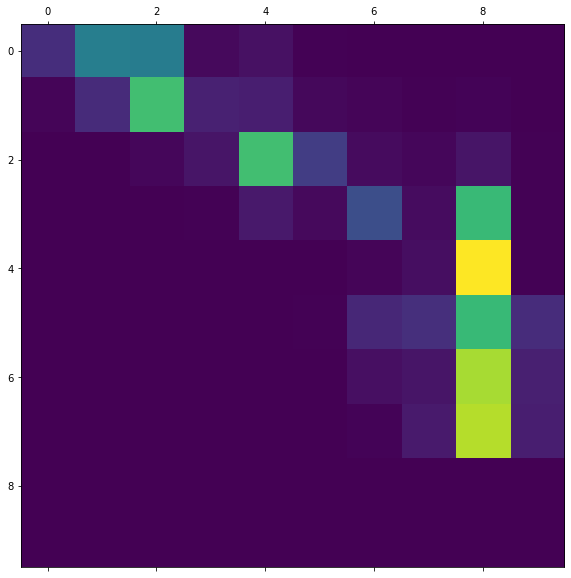

In [91]:
plot_attention(attn_weights, "j'ai besoin de quelqu'un pour m'aider ?", "i need someone to help me .")